In [36]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy.stats import kurtosis
from scipy.stats import skew
import scipy.stats as ss

In [38]:
# import merged dataset for Birds in four cities across different times
data = pd.read_csv('final_merge.csv', index_col=0)

# Plotting Distributions

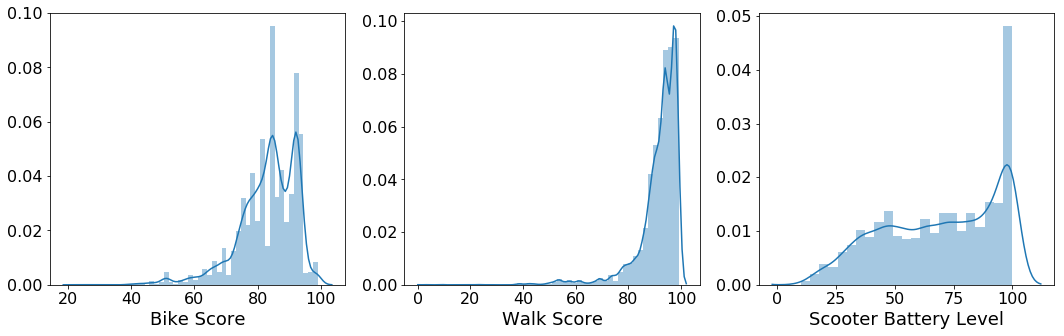

In [39]:
# Plot distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.tick_params(labelsize=16)
sns.distplot(data['bike_score'], ax=ax1); ax1.set_xlabel('Bike Score', fontsize=18)
sns.distplot(data['walk_score'], ax=ax2); ax2.set_xlabel('Walk Score', fontsize=18)
sns.distplot(data['battery_level'], ax=ax3); ax3.set_xlabel('Scooter Battery Level', fontsize=18);
ax1.tick_params(labelsize=16); ax2.tick_params(labelsize=16); ax3.tick_params(labelsize=16); 

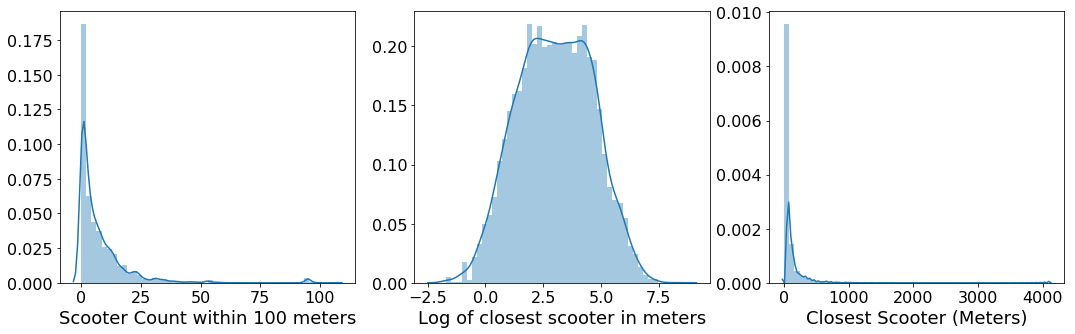

In [40]:
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(18, 5))
ax1.tick_params(labelsize=16)

sns.distplot(data['hundred_meter'], ax=ax4); ax4.set_xlabel('Scooter Count within 100 meters', fontsize=18)
sns.distplot(data['log_scooter'], ax=ax5); ax5.set_xlabel('Log of closest scooter in meters', fontsize=18)
sns.distplot(data['closest_scooter'], ax=ax6); ax6.set_xlabel('Closest Scooter (Meters)', fontsize=18)

ax4.tick_params(labelsize=16); ax5.tick_params(labelsize=16); ax6.tick_params(labelsize=16);

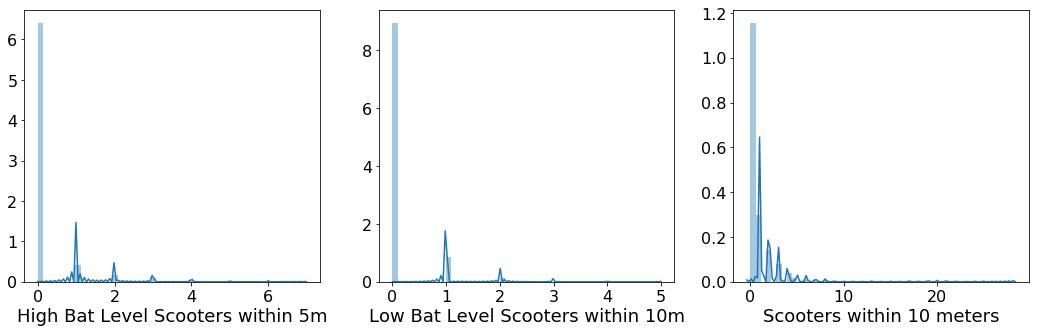

In [44]:
fig, (ax7, ax8, ax9) = plt.subplots(1, 3, figsize=(18, 5))
ax1.tick_params(labelsize=16)

sns.distplot(data['highest_bat_proximity'], ax=ax7); ax7.set_xlabel('High Bat Level Scooters within 5m', fontsize=18)
sns.distplot(data['low_bat_proximity'], ax=ax8); ax8.set_xlabel('Low Bat Level Scooters within 10m', fontsize=18)
sns.distplot(data['ten_meter'], ax=ax9); ax9.set_xlabel('Scooters within 10 meters', fontsize=18)

ax7.tick_params(labelsize=16); ax8.tick_params(labelsize=16); ax9.tick_params(labelsize=16);

# Statistical Analysis

In [51]:
data.groupby('nest_dummy')['bike_score'].mean()

nest_dummy
0    83.168605
1    82.786431
Name: bike_score, dtype: float64

In [52]:
# create stratified bike scores by nest_dummy
nest = data['bike_score'][data['nest_dummy'] == 1]
no_nest = data['bike_score'][data['nest_dummy'] == 0]

In [53]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   

In [54]:
test = t_test(nest, no_nest, 0.05)
test 

DegFreedom    3325.950479
Difference      -0.382174
Statistic       -1.755682
PValue           0.079235
Low95CI         -0.808972
High95CI         0.044623
dtype: float64

The PValue is greater than the 5% significance level and the 95% Confidence interval straddles 0 so we cannot reject the null hypothesis. This means there is a high chance that the difference in means is from random variation alone.

In [63]:
data.groupby('nest_dummy')['walk_score'].mean()

nest_dummy
0    91.206909
1    92.601051
Name: walk_score, dtype: float64

In [64]:
# create stratified walk scores by nest_dummy
nest = data['walk_score'][data['nest_dummy'] == 1]
no_nest = data['walk_score'][data['nest_dummy'] == 0]

In [65]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    4.257916e+03
Difference    1.394142e+00
Statistic     8.165327e+00
PValue        4.182608e-16
Low95CI       1.059404e+00
High95CI      1.728880e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of walk score by nest classification.

In [55]:
data.groupby('nest_dummy')['battery_level'].mean()

nest_dummy
0    62.900364
1    94.888199
Name: battery_level, dtype: float64

In [56]:
# create stratified battery level by nest_dummy
nest = data['battery_level'][data['nest_dummy'] == 1]
no_nest = data['battery_level'][data['nest_dummy'] == 0]

In [57]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    7941.339627
Difference      31.987835
Statistic       98.086971
PValue           0.000000
Low95CI         31.348559
High95CI        32.627110
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of battery levels by nest classification.

In [60]:
data.groupby('nest_dummy')['log_scooter'].mean()

nest_dummy
0    3.281436
1    1.891617
Name: log_scooter, dtype: float64

In [61]:
# create stratified log of closest scooter in meters by nest_dummy
nest = data['log_scooter'][data['nest_dummy'] == 1]
no_nest = data['log_scooter'][data['nest_dummy'] == 0]

In [62]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom     3.420579e+03
Difference    -1.389818e+00
Statistic     -3.966912e+01
PValue        1.856563e-283
Low95CI       -1.458511e+00
High95CI      -1.321126e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of log of closest scooter in meters by nest classification.

In [66]:
data.groupby('nest_dummy')['ten_meter'].mean()

nest_dummy
0    0.764305
1    1.751075
Name: ten_meter, dtype: float64

In [67]:
# create stratified scooters within 10 meters by nest_dummy
nest = data['ten_meter'][data['nest_dummy'] == 1]
no_nest = data['ten_meter'][data['nest_dummy'] == 0]

In [68]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    3.399688e+03
Difference    9.867700e-01
Statistic     1.715737e+01
PValue        2.391500e-63
Low95CI       8.740067e-01
High95CI      1.099533e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of scooter count within 10 meters by nest classification

# Additional Visualizations

Text(0.5,1,'Log Closest Scooter in Meters vs Walk Score \n with Nest Classification by color')

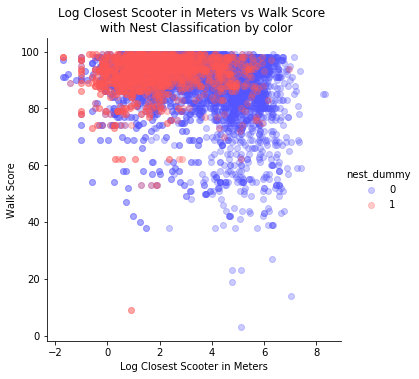

In [72]:
sns.lmplot(x = 'log_scooter', y = 'walk_score', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log Closest Scooter in Meters')
plt.ylabel('Walk Score')
plt.title('Log Closest Scooter in Meters vs Walk Score \n with Nest Classification by color')

Text(0.5,1,'Log Closest Scooter in Meters vs Battery Level \n with Nest Classification by color')

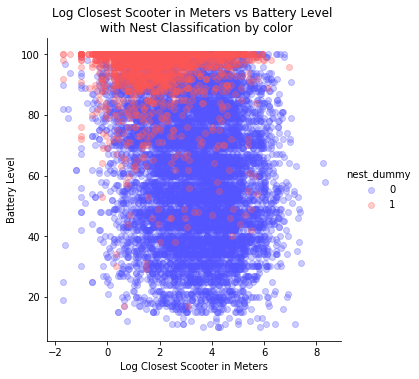

In [73]:
sns.lmplot(x = 'log_scooter', y = 'battery_level', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log Closest Scooter in Meters')
plt.ylabel('Battery Level')
plt.title('Log Closest Scooter in Meters vs Battery Level \n with Nest Classification by color')